In [1]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys
import import_ipynb
from sklearn.model_selection import train_test_split
import copy
%run ./Data_handling.ipynb
%run ./Data_visualization.ipynb
%run ./Model.ipynb
%run ./Analysis.ipynb

304
308
50


## Data handling

In [2]:
G1 = read_sumo_net1('../Data/s_gyor.net.xml') # type: ignore
#G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"0.00")
#pyg_data = nx_to_pyg(G2)
data_predict = torch.load('../generate/generated_files/data_predict_backup.pth')
data_predict_copy = copy.deepcopy(data_predict)

random_numbers = random.sample(range(len(data_predict)), int(len(data_predict)*0.3))
data_predict_test = [data_predict_copy[i] for i in random_numbers]
data_predict_train = [data_predict_copy[i] for i in range(len(data_predict_copy)) if i not in random_numbers]

with open('../gnn_outputs/edges_to_hide_10_smart.json', 'r') as file:
    edges_to_hide = json.load(file)
prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden = data_preparation_for_forecasting(data_predict_train,data_predict_test, edges_to_hide, True)


In [4]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
#data = torch.load('../Data/data.pth')

#edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, 150)
random.seed(20)
edges_to_hide = list(random.sample(range(504), int(504*0.7)))

#with open('../gnn_outputs/edges_to_hide_10_smart.json', 'r') as file:
#    edges_to_hide = json.load(file)

print(len(edges_to_hide))

352


## Initialization of the model

In [ ]:
data_predict = torch.load('../generate/generated_files/data_predict_backup.pth')
data_predict_copy = copy.deepcopy(data_predict)

random.seed(20)
random_numbers = random.sample(range(len(data_predict)), int(len(data_predict)*0.3))
data_predict_test = [data_predict_copy[i] for i in random_numbers]
data_predict_train = [data_predict_copy[i] for i in range(len(data_predict_copy)) if i not in random_numbers]

with open('../gnn_outputs/edges_to_hide_10_smart.json', 'r') as file:
    edges_to_hide = json.load(file)
prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden = data_preparation_for_forecasting(data_predict_train,data_predict_test, edges_to_hide, True)
number_of_epochs = 5000

# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 64
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses= training_the_model_forecasting(model, optimizer, criterion, number_of_epochs, prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden, edges_to_hide, 20, time_step=1)

#with open('total_losses.json', 'w') as file:
#    json.dump(total_losses, file)
#with open('losses.json', 'w') as file:
#    json.dump(losses, file)

Epoch 1, Loss: 0.01650485210120678 , Test loss: 0.010771970264613628 


In [ ]:
def run_and_save_forecasting(seed, percent, name):
    random.seed(seed)
    knownedges = int((1-percent)*500)
    data_predict = torch.load('../generate/generated_files/data_predict_backup.pth')
    data_predict_copy = copy.deepcopy(data_predict)
    edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, knownedges)
    

    random_numbers = random.sample(range(len(data_predict)), int(len(data_predict)*0.3))
    data_predict_test = [data_predict_copy[i] for i in random_numbers]
    data_predict_train = [data_predict_copy[i] for i in range(len(data_predict_copy)) if i not in random_numbers]
    prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden = data_preparation_for_forecasting(data_predict_train,data_predict_test, edges_to_hide, True)
    number_of_epochs = 5000
    # Define the model
    edge_dim = 1  # Number of edge features
    hidden_dim1 = 32
    hidden_dim2 = 64
    hidden_dim3 = 64
    hidden_dim4 = 32
    hidden_dim5 = 32
    hidden_dim6 = 32
    hidden_dim7 = 32
    hidden_dim8 = 32

    model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses= training_the_model_forecasting(model, optimizer, criterion, number_of_epochs, prepared_training_data, prepared_training_data_hidden, prepared_test_data, prepared_test_data_hidden, edges_to_hide, 20, time_step=1)
    losses_to_save = [ losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses]
    
    directory = '../forecasting/'
    lossname = directory + 'losses_' + str(percent) + '_smart_5_' + str(name) + '.json'
    modelname = directory + 'gnn_model_ces_' + str(percent) + '_smart_5_' + str(name) + '.json'
    edgesname = directory + 'edges_to_hide' + str(percent) + '_smart_5_' + str(name) + '.json'


    with open(lossname, 'w') as file:
        json.dump(losses_to_save, file)

    torch.save(model.state_dict(), modelname)

    with open(edgesname, 'w') as file:
        json.dump(edges_to_hide, file)
    

In [9]:
run_and_save_forecasting(21, 0.8, 'v15')

Epoch 1, Loss: 0.007752672303467989 , Test loss: 0.0012821273412555456 


In [ ]:
def run_and_save(seed, percent, name):
    random.seed(seed)
    #edges_to_hide = list(random.sample(range(504), int(504*percent)))
    knownedges = int((1-percent)*500)
    data = torch.load('../Data/data.pth')
    edges_to_hide = choose_hidden_edges_well(data, '../Data/s_gyor.net.xml', 3, 7, 0.3, knownedges)
    G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
    #with open('../Data/edges_to_hide.json', 'r') as file:
    #    edges_to_hide = json.load(file)
    

    #data_train , data_test = train_test_split(data, test_size=0.3 , shuffle=True)

    data_train = torch.load('../Data/data_train.pth')
    data_test = torch.load('../Data/data_test.pth')

    prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, summa = data_preparation(data_train, data_test, edges_to_hide, True)
    print(summa)


    # Define the model
    edge_dim = 1  # Number of edge features
    hidden_dim1 = 32
    hidden_dim2 = 64
    hidden_dim3 = 64
    hidden_dim4 = 32
    hidden_dim5 = 32
    hidden_dim6 = 32
    hidden_dim7 = 32
    hidden_dim8 = 32

    model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses= training_the_model(model, optimizer, criterion, 5000, prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, edges_to_hide, 20)
    losses_30_smart = [ losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses]

    lossname = 'losses_' + str(percent) + '_smart_5_' + str(name) + '.json'
    modelname = 'gnn_model_ces_' + str(percent) + '_smart_5_' + str(name) + '.json'
    edgesname = 'edges_to_hide' + str(percent) + '_smart_5_' + str(name) + '.json'


    with open(lossname, 'w') as file:
        json.dump(losses_30_smart, file)

    torch.save(model.state_dict(), modelname)

    with open(edgesname, 'w') as file:
        json.dump(edges_to_hide, file)

In [14]:
runs_10 =[[21, 0.8, 'v2'], [22, 0.8, 'v3'], [23, 0.8, 'v4'], [24, 0.8, 'v5'], [26, 0.8, 'v6'], [27, 0.8, 'v7'], [28, 0.8, 'v8']
          , [36, 0.9, 'v6'], [37, 0.9, 'v7'], [38, 0.9, 'v8'], [46, 0.7, 'v6'], [47, 0.7, 'v7'], [48, 0.7, 'v8'], [49, 0.7, 'v9'], 
          [50, 0.7, 'v10'], [39, 0.8, 'v9'], [30, 0.8, 'v10'], [89, 0.9, 'v9'], [80, 0.9, 'v10'],
          [11, 0.9, 'v2'], [12, 0.9, 'v3'], [13, 0.9, 'v4'], [14, 0.9, 'v5'],
          [121, 0.7, 'v2'], [122, 0.7, 'v3'], [123, 0.7, 'v4'], [124, 0.7, 'v5'],]
for i in runs_10:
    run_and_save(i[0],i[1],i[2])

tensor(0.0081)
Epoch 1, Loss: 0.003648323006927967 , Test loss: 0.0035665833856910467 
Epoch 21, Loss: 0.003111392492428422 , Test loss: 0.004569678101688623 
Epoch 41, Loss: 0.004333028569817543 , Test loss: 0.004441884811967611 
Epoch 61, Loss: 0.003731047734618187 , Test loss: 0.004303740803152323 
Epoch 81, Loss: 0.003550469409674406 , Test loss: 0.0042925430461764336 
Epoch 101, Loss: 0.003228371264412999 , Test loss: 0.004437665455043316 
Epoch 121, Loss: 0.005410559941083193 , Test loss: 0.004146077670156956 
Epoch 141, Loss: 0.004008329473435879 , Test loss: 0.0033241468481719494 
Epoch 161, Loss: 0.0035034867469221354 , Test loss: 0.004147539846599102 
Epoch 181, Loss: 0.0035944939590990543 , Test loss: 0.003340392839163542 
Epoch 201, Loss: 0.0034511906560510397 , Test loss: 0.0038544470444321632 
Epoch 221, Loss: 0.005040512420237064 , Test loss: 0.004569391719996929 
Epoch 241, Loss: 0.004490423481911421 , Test loss: 0.00475655123591423 
Epoch 261, Loss: 0.00383382500149309

: 

In [5]:
torch.save(model.state_dict(), 'gnn_model_ces.pth')
#cep : change every step
layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6, model.conv7, model.conv8]
edge_dims = []
for layer in layers:
    edge_dims.append(layer.in_channels)
edge_dims.append(model.linear.in_features)
with open('dimensions.json','w') as file:
    json.dump(edge_dims, file)


## Loading the model
Once we trained it nd saved it, this is how we can load it

In [ ]:
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('gnn_model_ces.pth'))
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)



## Data visualization

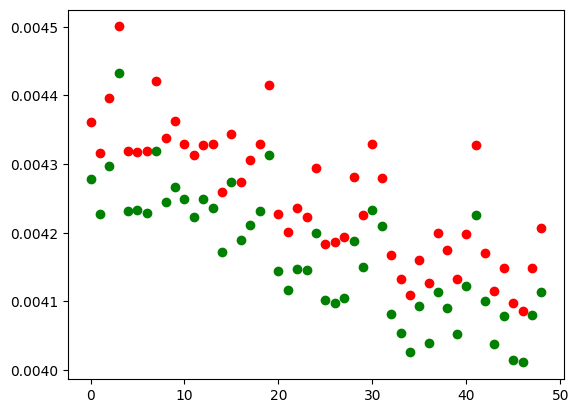

In [25]:
plt.plot(total_train_losses[1:], 'ro', total_test_losses[1:], 'go')
plt.show()

In [151]:
smart30test = total_test_losses
smart30train = total_train_losses

In [102]:
random30test = total_test_losses
random30train = total_train_losses


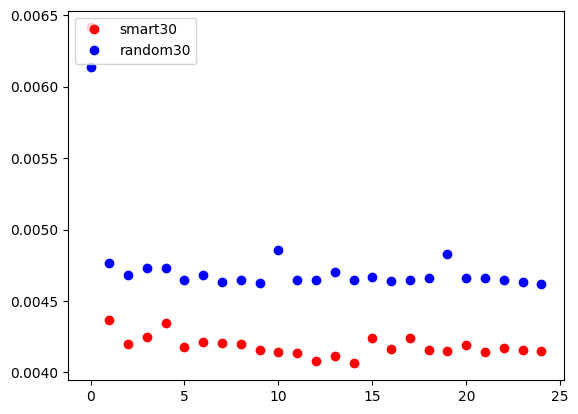

In [152]:
plt.plot(smart30test, 'ro', label = "smart30")
plt.plot(random30test, 'bo', label = "random30")
plt.legend(loc="upper left")
plt.show()

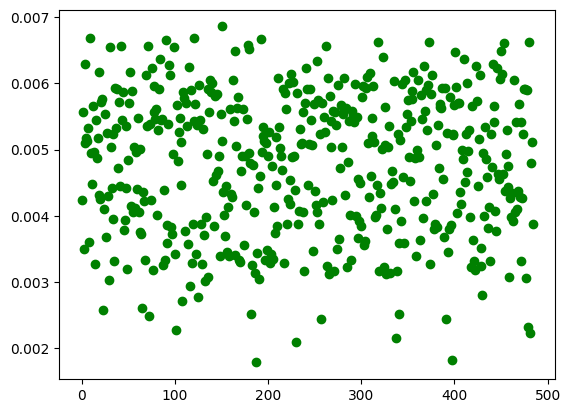

In [164]:
#plt.yscale("log")
plt.plot(losses[15:], 'go')
plt.show()

In [18]:
losses_30_smart = [ losses, total_train_losses, total_test_losses ,test_losses,total_geh_losses]
with open('losses_30_random_5k_v5.json', 'w') as file:
    json.dump(losses_30_smart, file)

In [17]:
torch.save(model.state_dict(), 'gnn_model_ces_30_random_5k_v5.pth')

In [16]:
with open('edges_to_hide_30_ransom.json_5k_v5', 'w') as file:
    json.dump(edges_to_hide, file)

In [146]:
mod = [8, 16, 32, 16, 8, 8, 4, 4]
with open('mod_9.json', 'w') as file:
    json.dump(mod, file)

In [147]:
%run ./Data_visualization.ipynb

In [171]:
with open('../gnn_outputs/edges_to_hide_30_smart.json', 'r') as file:
    edges_to_hide = json.load(file)

In [172]:
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
#with open('../Data/edges_to_hide.json', 'r') as file:
#    edges_to_hide = json.load(file)
data = torch.load('../Data/data.pth')

data_train , data_test = train_test_split(data, test_size=0.3 , shuffle=True)

#data_train = torch.load('../Data/data_train.pth')
#data_test = torch.load('../Data/data_test.pth')

prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, summa = data_preparation(data_train, data_test, edges_to_hide, True)
print(summa)

tensor(0.0081)


In [64]:
prepared_test_data.edge_attr

AttributeError: 'list' object has no attribute 'edge_attr'

In [74]:
prepared_test_data[3].edge_attr


tensor([[0.1178],
        [0.0000],
        [0.1878],
        [0.1711],
        [0.0267],
        [0.0267],
        [0.0011],
        [0.0233],
        [0.0233],
        [0.0889],
        [0.0889],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0889],
        [0.1200],
        [0.0889],
        [0.1078],
        [0.1078],
        [0.0156],
        [0.1078],
        [0.0211],
        [0.0211],
        [0.0000],
        [0.0211],
        [0.0000],
        [0.2800],
        [0.1422],
        [0.3011],
        [0.0200],
        [0.0000],
        [0.0122],
        [0.0122],
        [0.0100],
        [0.0056],
        [0.0044],
        [0.0622],
        [0.0644],
        [0.1522],
        [0.1589],
        [0.1567],
        [0.1544],
        [0.0533],
        [0.0000],
        [0.2167],
        [0.0889],
        [0.0889],
        [0.1200],
        [0.0889],
        [0.0889],
        [0.0911],
        [0.1567],
        [0.1544],
        [0.1544],
        [0.0011],
        [0

In [44]:
prepared_test_data_hiden[3].edge_attr

tensor([[ 5.2394e-04],
        [ 0.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [ 1.3550e-04],
        [-1.0000e+00],
        [ 2.7100e-05],
        [ 2.7100e-05],
        [ 3.2972e-04],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [ 0.0000e+00],
        [ 2.8907e-04],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.1111e-03],
        [-1.1111e-03],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [ 9.8464e-04],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [-1.0000e+00],
        [ 1.3550e-05],
        [-1.1111e-03],
        [ 3.2069e-04],
        [-1.0000e+00],
        [-1.0000e+00],
        [ 7.3171e-04],
        [ 7.1364e-04],
        [-1.0000e+00],
        [-1

In [173]:

with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('../gnn_outputs/gnn_model_ces_30_smart.pth'))
output = model2(prepared_training_data[3].edge_attr, prepared_training_data[3].edge_index)


In [8]:
print(len(prepared_training_data[3].edge_attr))

504


In [165]:
output = model(prepared_training_data_hiden[3].edge_attr, prepared_training_data_hiden[3].edge_index)

In [27]:
print(prepared_training_data[3].edge_attr.count(prepared_training_data[3].edge_attr[3]))

AttributeError: 'Tensor' object has no attribute 'count'

In [30]:
a = []
for i in prepared_training_data[3].edge_attr:
    a.append(float(i))
print(a)
print(a.count(a[3]))

[0.00034778681583702564, 0.0, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, 7.67841047490947e-05, -0.0011111111380159855, 4.516711487667635e-05, 4.516711487667635e-05, 0.00021680216013919562, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, 0.0, 0.00021680216013919562, -0.0011111111380159855, -0.0011111111380159855, 0.00026648599305190146, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, 0.0010975609766319394, 0.0005962059949524701, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, -0.0011111111380159855, 3.161698259646073e-05, -0.0011111111380159855, -0.0011111111380159855, 1.3550135008699726e-05, -0.0011111111380159855, 0.00027100270381197333, 0.0005555555690079927, -0.0011111111380159855, 0.000510388461407274, 0.0004832881677430123, -0.0011111111380159855, -0.0011111111380

354
[2, 3, 4, 6, 10, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 32, 33, 34, 36, 39, 42, 43, 45, 47, 49, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 67, 68, 69, 70, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 89, 90, 91, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 137, 138, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 156, 158, 159, 160, 162, 163, 164, 165, 167, 170, 171, 172, 173, 174, 176, 177, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190, 191, 193, 195, 196, 198, 200, 202, 203, 205, 206, 207, 210, 211, 212, 214, 215, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 235, 237, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 251, 252, 254, 256, 259, 260, 261, 262, 263, 266, 268, 270, 271, 272, 274, 275, 276, 277, 278, 279, 281, 283, 285, 286, 288, 289, 290, 291, 293, 294, 295,

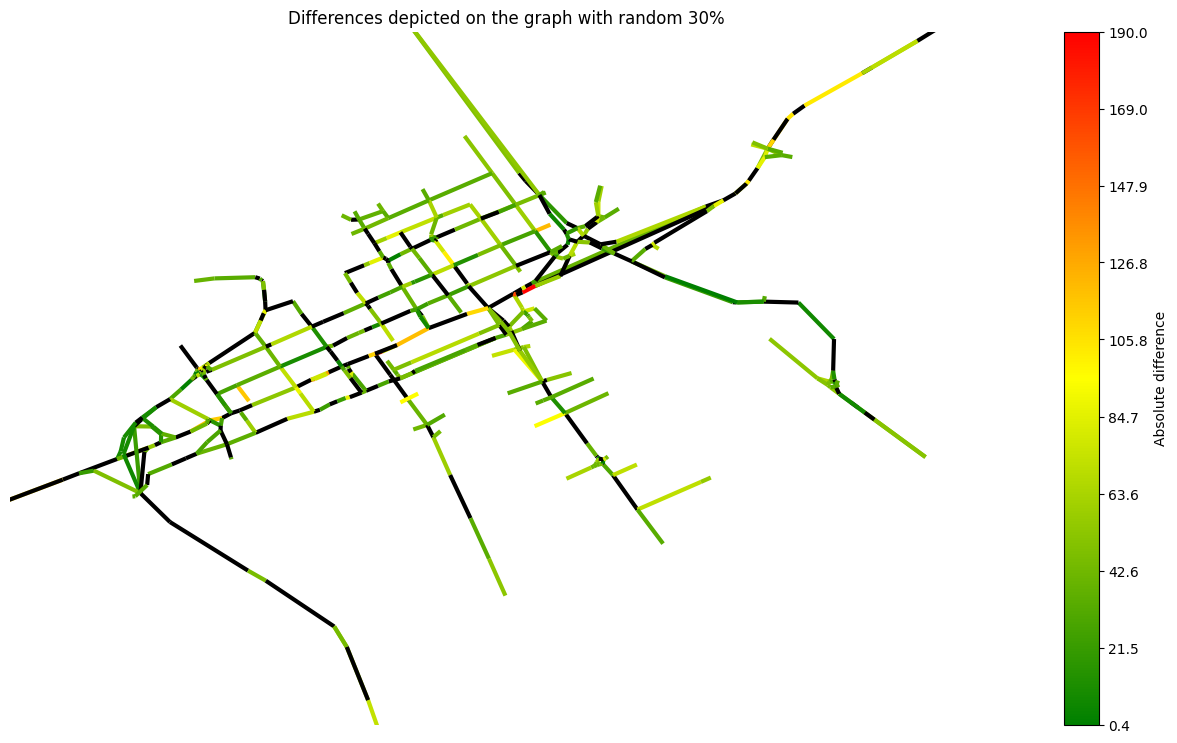

In [174]:

plot_graph_weight(G1, output, edges_to_hide,prepared_training_data[3] )

352
[1, 2, 3, 4, 5, 7, 11, 14, 15, 16, 17, 18, 19, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 37, 38, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 60, 61, 63, 65, 67, 70, 71, 72, 73, 74, 77, 78, 79, 81, 82, 83, 84, 85, 86, 89, 90, 92, 95, 96, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 111, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 129, 130, 131, 132, 133, 134, 135, 138, 139, 141, 142, 143, 144, 147, 148, 149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166, 168, 169, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181, 182, 183, 186, 189, 190, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 211, 212, 213, 214, 215, 216, 219, 222, 223, 224, 225, 227, 228, 229, 230, 234, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 255, 256, 257, 258, 260, 262, 263, 264, 265, 266, 267, 268, 269, 271, 273, 274, 275, 279, 280, 284, 285, 286, 287, 288, 290, 293, 294, 296, 297, 298, 300, 302, 303, 305, 307

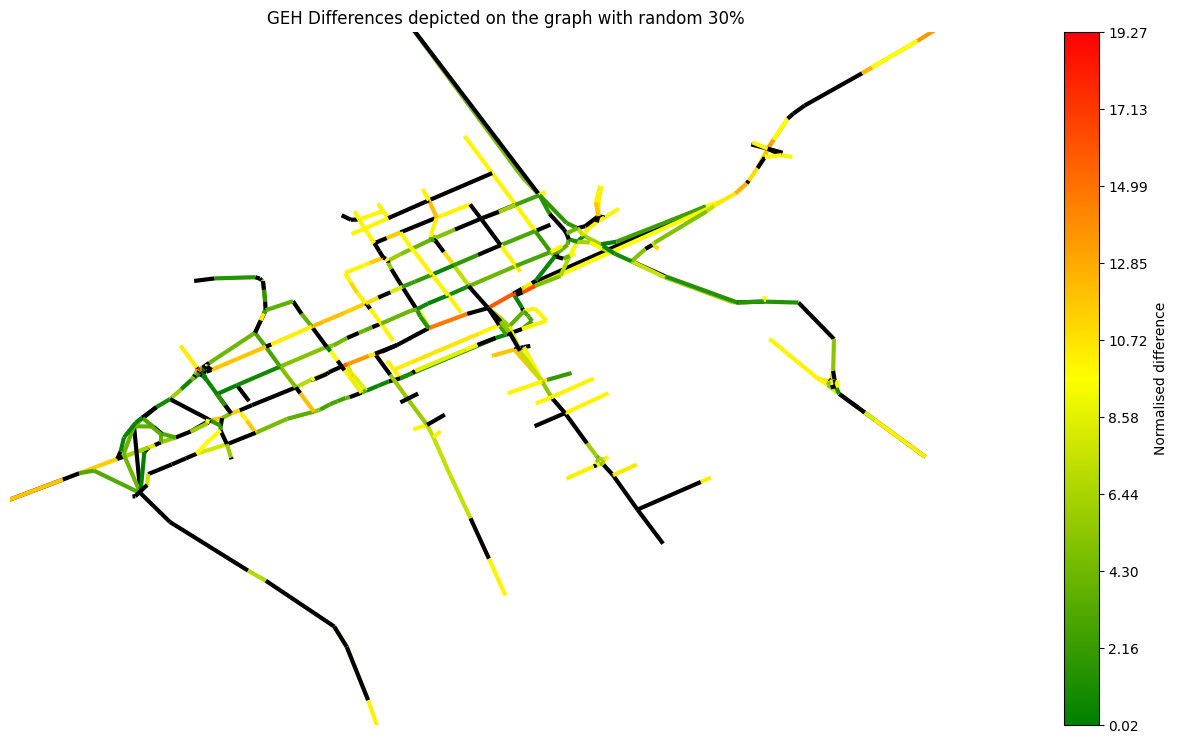

In [121]:
plot_graph_weight_GEH(G1, output, edges_to_hide,prepared_training_data[3] )